In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Subset, DataLoader
from argparse import Namespace
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from cassava.utils import *
from cassava.transforms import get_test_transforms
from cassava.models.model import LeafDoctorModel
from cassava.pipelines.train_model.nodes import score_model
from cassava.pipelines.train_model.nodes import split_data, train_model

In [4]:
!pip install captum

You should consider upgrading via the '/home/boris/Documents/kaggle cassava/venv/bin/python3 -m pip install --upgrade pip' command.


In [5]:
from captum.attr import GuidedGradCam,  DeepLift, Occlusion, NoiseTunnel, IntegratedGradients
from captum.attr import visualization as viz

In [6]:
parameters = context.catalog.load('parameters')

2020-12-26 23:47:30,948 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [7]:
train = context.catalog.load('train')

2020-12-26 23:47:30,995 - kedro.io.data_catalog - INFO - Loading data from `train` (ImageOneFolderDataSet)...


In [8]:
train.labels = (train.sources == 'train_2020').astype(int)

In [9]:
train_idx, test_idx = train_test_split(range(len(train)), stratify=train.labels, random_state=42)
len(train_idx), len(test_idx)

(19749, 6583)

In [10]:
pd.Series(train.labels[test_idx]).value_counts()

1    5349
0    1234
dtype: int64

In [11]:
test = DatasetFromSubset(Subset(train, indices=test_idx))

In [12]:
train = DatasetFromSubset(Subset(train, indices=train_idx))

# Train model to predict which dataset a picture came from

In [13]:
train_indices, val_indices = split_data(train, parameters)

In [14]:
hparams = Namespace(**parameters['classifier'])
model = LeafDoctorModel(hparams)

In [15]:
model = train_model(model, train, train_indices, val_indices, parameters)

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory data/06_models/classifier/checkpoints exists and is not empty. With save_top_k=1, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True


2020-12-26 23:47:31,332 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-26 23:47:31,334 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-26 23:47:31,335 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using native 16bit precision.


2020-12-26 23:47:31,337 - lightning - INFO - Using native 16bit precision.



  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


2020-12-26 23:47:34,650 - lightning - INFO - 
  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


Epoch 0: val_acc reached 0.94701 (best 0.94701), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.9470.ckpt as top 1


2020-12-26 23:53:03,341 - lightning - INFO - Epoch 0: val_acc reached 0.94701 (best 0.94701), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.9470.ckpt as top 1


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 1: val_acc was not in top 1


2020-12-26 23:53:10,108 - lightning - INFO - Epoch 1: val_acc was not in top 1

2020-12-26 23:53:10,185 - root - INFO - Training finished


Test accuracy

In [16]:
score_model(model, test, list(range(len(test))), parameters)[0]

2020-12-26 23:53:10,554 - root - INFO - Scoring model



2020-12-26 23:53:40,438 - root - INFO - Validation scores:
{'accuracy': 0.9519975694971897, 'f1_score': 0.9539978260452815}


{'accuracy': 0.9519975694971897, 'f1_score': 0.9539978260452815}

# Interpret this craziness

## Applying guided grad CAM

In [17]:
model = model.eval()
model = model.cpu()

In [18]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [19]:
def get_attribution(model, image, source, label):
    prep_image_batch = image.unsqueeze(0)
    prediction = model.predict(prep_image_batch)[0]
    
    print('True:', source)
    print('Pred:', 'train_2020' if prediction else 'train_2019')

    n_samples = 5

    attributor = GuidedGradCam(model, model.trunk.blocks[6][0].conv_pwl)
    attributor = NoiseTunnel(attributor)
    attribution = attributor.attribute(prep_image_batch,
                                       target=target,
                                      n_samples=n_samples)


    # attributor = DeepLift(model)
    # attributor = NoiseTunnel(attributor)
    # attribution = attributor.attribute(prep_image_batch,
    #                                    target=target,
    #                                   baselines=0, n_samples=n_samples)



    # attributor = Occlusion(model)
    # strides = (3, 5, 5) 
    # sliding_window_shapes=(3,50,50)
    # target = int(label)
    # baselines = 0

    # attribution = attributor.attribute(prep_image_batch,
    #                                    target=target,
    #                                    sliding_window_shapes=sliding_window_shapes,
    #                                    strides=strides,
    #                                    baselines=baselines)

    attribution = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0))
    return attribution

def visualize_attribution(image, attribution):
    vis_types = ["heat_map", "blended_heat_map", "original_image"]
    vis_signs = ["all", "all", "all"] # "positive", "negative", or "all" to show both
    # positive attribution indicates that the presence of the area increases the prediction score
    # negative attribution indicates distractor areas whose absence increases the score

    _ = viz.visualize_image_attr_multiple(attribution,
                                          unnorm(image.clone()).permute((2, 1, 0)).numpy(),
                                          vis_types,
                                          vis_signs,
                                          vis_types,
                                          show_colorbar = True,
                                          fig_size=(20, 10)
                                         )

### Random train image

In [20]:
indices_2019 = np.argwhere(train.subset.dataset.sources[train.subset.indices] == 'train_2019').flatten()

True: train_2019
Pred: train_2019


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:60: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


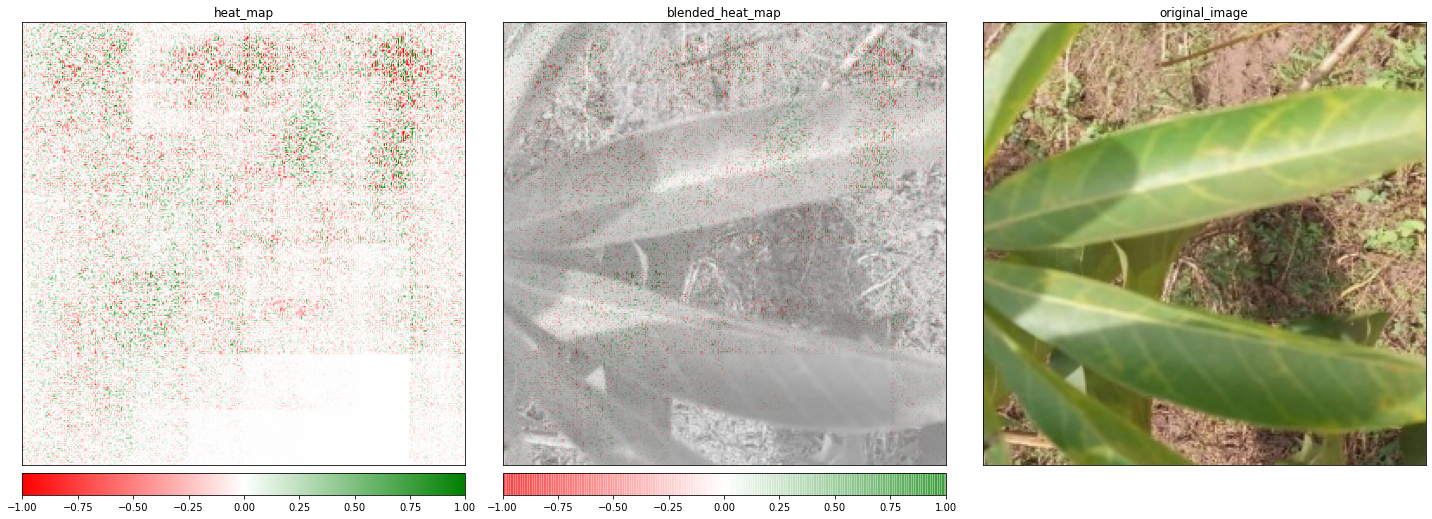

In [21]:
idx = np.random.choice(indices_2019)
source = train.subset.dataset.sources[train.subset.indices][idx]

image, label = train[idx]
prep_image = get_test_transforms()(image=image)['image']
target = int(label)

attribution = get_attribution(model, prep_image, source, label)

visualize_attribution(prep_image, attribution)


### Random test image

In [24]:
indices_2019_test = np.argwhere(test.subset.dataset.sources[test.subset.indices] == 'train_2019').flatten()
indices_2020_test = np.argwhere(test.subset.dataset.sources[test.subset.indices] == 'train_2020').flatten()

train_2020
True: train_2020
Pred: train_2020


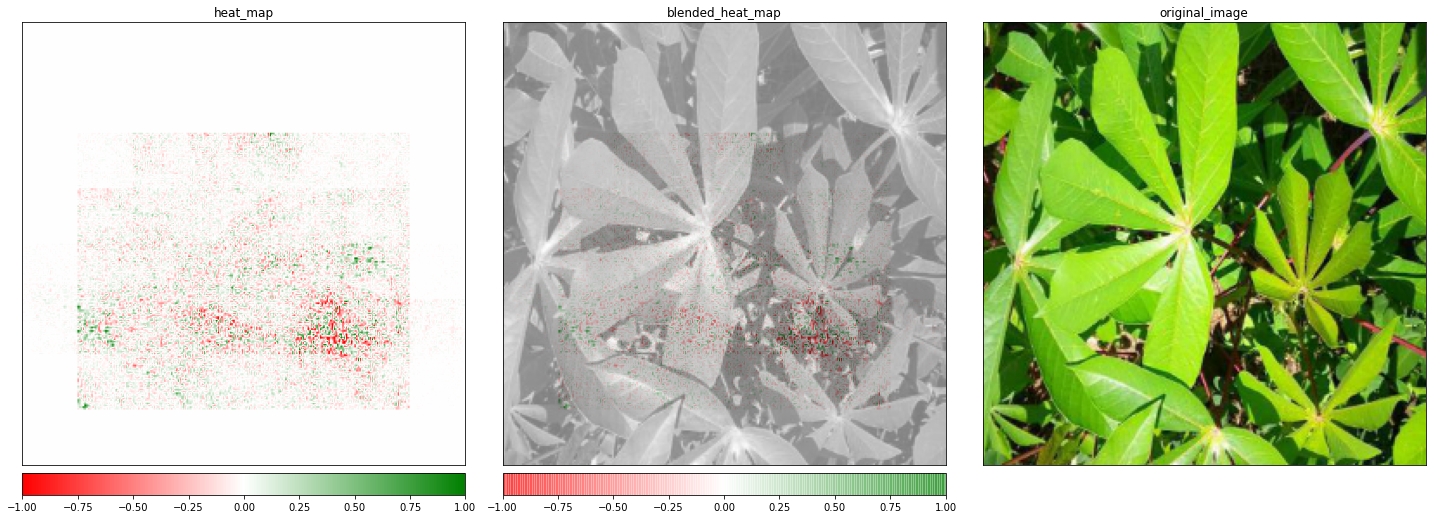

In [26]:
idx = np.random.choice(indices_2020_test)
source = test.subset.dataset.sources[test.subset.indices][idx]
print(source)

image, label = test[idx]
prep_image = get_test_transforms()(image=image)['image']
target = int(label)

attribution = get_attribution(model, prep_image, source, label)

visualize_attribution(prep_image, attribution)

